#TECH CHALLENGE - FASE 3: MACHINE LEARNING ENGINEERING
Esqueleto de Código para Análise de Atrasos de Voos

In [1]:
# -------------------------------------------------------------------
# TECH CHALLENGE - FASE 3: MACHINE LEARNING ENGINEERING
# Esqueleto de Código para Análise de Atrasos de Voos
# -------------------------------------------------------------------

In [2]:
# --- Importar Bibliotecas --- #

# --- 1. Importações e Configurações ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import joblib
from functools import partial

# Scikit-Learn e Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score, classification_report
from sklearn.inspection import permutation_importance

# Modelos
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

# Category Encoders
from category_encoders import TargetEncoder, CountEncoder


c:\Users\igor_\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Configura o Pandas para mostrar todas as colunas em dataframes
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.2f}'.format

In [4]:
def verify_null_counts(data):

  """
  Verify null counts and null percent
  """

  total_rows = len(data)
  null_counts = data.isnull().sum()

  null_percentage = (null_counts / total_rows) * 100
  null_data = null_counts[null_counts > 0]

  if null_data.empty:
      print("Nenhum valor nulo encontrado.")
  else:
      for col in null_data.index:
          print(f'{col}: {null_data[col]} ({null_percentage[col]:.2f}%)')

In [5]:
def print_statics_values(data_dict):
  '''
  Input : Data dictonary
  Output : Data shape, Data describe , Data info for each dataframe inside in the dict
  '''
  for name, key in data_dict.items():
        print("=" * 60)
        print(f"=== DataFrame: {name} ===")

        print(f"Shape: {key.shape}")

        print("\nDescribe:")
        print(key.describe())

        print("\nInfo:")
        key.info()

        print("=" * 60, "\n")


# Exploração dos dados (EDA)

In [6]:
# Carregando os 3 arquivos de dados
try:
    # Adicionando 'on_bad_lines="skip"' para ignorar linhas malformadas
    df_flights = pd.read_csv('flights.csv', on_bad_lines='skip')
    df_airlines = pd.read_csv('airlines.csv')
    df_airports = pd.read_csv('airports.csv')
    print("Arquivos carregados com sucesso.")
except FileNotFoundError as e:
    print(f"Erro ao carregar arquivo: {e}")
    print("Certifique-se de que os 3 arquivos CSV estão no mesmo diretório do seu notebook.")
    # Se der erro, não podemos continuar
    raise e

C:\Users\igor_\AppData\Local\Temp\ipykernel_15640\957969633.py:4: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_flights = pd.read_csv('flights.csv', on_bad_lines='skip')


Arquivos carregados com sucesso.


In [7]:
dataframes = {
    'Flights':df_flights,
    'Airlines':df_airlines,
    'Airports':df_airports
}

In [8]:
print_statics_values(dataframes)

=== DataFrame: Flights ===
Shape: (5819079, 31)

Describe:
            YEAR      MONTH        DAY  DAY_OF_WEEK  FLIGHT_NUMBER  \
count 5819079.00 5819079.00 5819079.00   5819079.00     5819079.00   
mean     2015.00       6.52      15.70         3.93        2173.09   
std         0.00       3.41       8.78         1.99        1757.06   
min      2015.00       1.00       1.00         1.00           1.00   
25%      2015.00       4.00       8.00         2.00         730.00   
50%      2015.00       7.00      16.00         4.00        1690.00   
75%      2015.00       9.00      23.00         6.00        3230.00   
max      2015.00      12.00      31.00         7.00        9855.00   

       SCHEDULED_DEPARTURE  DEPARTURE_TIME  DEPARTURE_DELAY   TAXI_OUT  \
count           5819079.00      5732926.00       5732926.00 5730032.00   
mean               1329.60         1335.20             9.37      16.07   
std                 483.75          496.42            37.08       8.90   
min           

In [9]:
df_airlines.head()

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways


In [10]:
df_airports.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65,-75.44
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41,-99.68
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04,-106.61
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.45,-98.42
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.54,-84.19


In [11]:
df_flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.00,-11.00,21.00,15.00,205.00,194.00,169.00,1448,404.00,4.00,430,408.00,-22.00,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.00,-8.00,12.00,14.00,280.00,279.00,263.00,2330,737.00,4.00,750,741.00,-9.00,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.00,-2.00,16.00,34.00,286.00,293.00,266.00,2296,800.00,11.00,806,811.00,5.00,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.00,-5.00,15.00,30.00,285.00,281.00,258.00,2342,748.00,8.00,805,756.00,-9.00,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.00,-1.00,11.00,35.00,235.00,215.00,199.00,1448,254.00,5.00,320,259.00,-21.00,0,0,NaN,NaN,NaN,NaN,NaN,NaN


#  Verificar valores ausentes antes do tratamento  #


In [12]:
verify_null_counts(df_airlines)

Nenhum valor nulo encontrado.


In [13]:
verify_null_counts(df_airports)

LATITUDE: 3 (0.93%)
LONGITUDE: 3 (0.93%)


In [14]:
verify_null_counts(df_flights)

TAIL_NUMBER: 14721 (0.25%)
DEPARTURE_TIME: 86153 (1.48%)
DEPARTURE_DELAY: 86153 (1.48%)
TAXI_OUT: 89047 (1.53%)
WHEELS_OFF: 89047 (1.53%)
SCHEDULED_TIME: 6 (0.00%)
ELAPSED_TIME: 105071 (1.81%)
AIR_TIME: 105071 (1.81%)
WHEELS_ON: 92513 (1.59%)
TAXI_IN: 92513 (1.59%)
ARRIVAL_TIME: 92513 (1.59%)
ARRIVAL_DELAY: 105071 (1.81%)
CANCELLATION_REASON: 5729195 (98.46%)
AIR_SYSTEM_DELAY: 4755640 (81.72%)
SECURITY_DELAY: 4755640 (81.72%)
AIRLINE_DELAY: 4755640 (81.72%)
LATE_AIRCRAFT_DELAY: 4755640 (81.72%)
WEATHER_DELAY: 4755640 (81.72%)


In [15]:
# Renomear coluna para evitar conflito no merge
df_airlines.rename(columns={'AIRLINE': 'AIRLINE_NAME'}, inplace=True)

In [16]:
# Juntar flights com airlines para ter os nomes das companhias
df_flights_completo = pd.merge(df_flights, df_airlines, left_on ='AIRLINE', right_on ='IATA_CODE', how='left')
print(f"Merge de 'flights' e 'airlines' concluído. Total de linhas: {len(df_flights_completo)}")
print(df_flights_completo[['YEAR', 'AIRLINE', 'IATA_CODE', 'AIRLINE_NAME', 'ARRIVAL_DELAY']].head())

Merge de 'flights' e 'airlines' concluído. Total de linhas: 5819079
   YEAR AIRLINE IATA_CODE            AIRLINE_NAME  ARRIVAL_DELAY
0  2015      AS        AS    Alaska Airlines Inc.         -22.00
1  2015      AA        AA  American Airlines Inc.          -9.00
2  2015      US        US         US Airways Inc.           5.00
3  2015      AA        AA  American Airlines Inc.          -9.00
4  2015      AS        AS    Alaska Airlines Inc.         -21.00


In [17]:
df_flights_completo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 33 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED             int64  
 24

# DEFINIÇÃO DAS LISTAS E COLUNAS PARA LIMPEZA E PRÉ-PROCESSAMENTO (DATA CLEANING)

Objetivo será tratar os dados a partir da informação se um voo foi cancelado ou não para definir as demais limpezas

In [18]:
#Variavel com colunas de voos com delay para consultarmos
delay_columns = ['DEPARTURE_DELAY', 'ARRIVAL_DELAY', 'AIR_SYSTEM_DELAY',
                 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY',
                 'TAXI_OUT', 'WHEELS_OFF', 'ELAPSED_TIME', 'AIR_TIME', 'WHEELS_ON', 'TAXI_IN', 'ARRIVAL_TIME', 'DEPARTURE_TIME'
]

# Consultar se há dados incorretamente gravados, pois se um voo foi cancelado (CANCELLED == 1), ele não deveria ter dados de voo da coluna delay. Após essa verificação, preencheremos esses valores com 0.
cancelled_flights = df_flights_completo['CANCELLED'] == 1
df_flights_completo.loc[cancelled_flights, delay_columns] = df_flights_completo.loc[cancelled_flights, delay_columns].fillna(0)

In [19]:
# Nota-se que todas colunas CANCELLED e CANCELLATION_REASON possuem relação, pois quando CANCELLED == 1, CANCELLATION_REASON sempre possui um valor (A, B, C ou D). 
# Quando CANCELLED == 0, CANCELLATION_REASON é NaN. Portanto, ambas colunas podem ser mantidas para análises futuras.
df_flights_completo['CANCELLED'].value_counts()

CANCELLED
0    5729195
1      89884
Name: count, dtype: int64

In [20]:
df_flights_completo['CANCELLATION_REASON'].value_counts()

CANCELLATION_REASON
B    48851
A    25262
C    15749
D       22
Name: count, dtype: int64

In [21]:
razoes_cancelamento = {
    'A': 'Airline',
    'B': 'Weather',
    'C': 'NAS',      # Sigla para "National Airspace System"
    'D': 'Security'
}

df_flights_completo['CANCELLATION_REASON'] = df_flights_completo['CANCELLATION_REASON'].replace(razoes_cancelamento)

df_flights_completo['CANCELLATION_REASON'].value_counts()

CANCELLATION_REASON
Weather     48851
Airline     25262
NAS         15749
Security       22
Name: count, dtype: int64

In [22]:
# Colunas onde NaN significa '0' em voos NÃO CANCELADOS. Se o voo não foi cancelado e as colunas de delay estão vazias, considera-se que o atraso foi zero.
colunas_componentes_delay = [
    'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
    'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'CANCELLATION_REASON'
]

nao_cancelado =df_flights_completo['CANCELLED'] == 0
df_flights_completo.loc[nao_cancelado, colunas_componentes_delay] = df_flights_completo.loc[nao_cancelado, colunas_componentes_delay].fillna(0)

C:\Users\igor_\AppData\Local\Temp\ipykernel_15640\3199230913.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_flights_completo.loc[nao_cancelado, colunas_componentes_delay] = df_flights_completo.loc[nao_cancelado, colunas_componentes_delay].fillna(0)


In [23]:
# Dropar linhas onde informações essenciais estão faltando e não faz sentido haver valores nulos
df_flights_completo.dropna(subset=['AIRLINE_NAME', 'TAIL_NUMBER', 'SCHEDULED_TIME','ARRIVAL_DELAY', 'DISTANCE'], inplace=True)

In [24]:
# Organizar as informações de data
df_flights_completo['FLIGHT_DATE'] = pd.to_datetime(df_flights_completo[['YEAR', 'MONTH', 'DAY']])
df_flights_completo.drop(columns=['YEAR', 'MONTH', 'DAY'], inplace=True)

In [25]:
# Converter colunas de tempo/atraso para Inteiro
int_columns = [
    'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME',
    'ELAPSED_TIME', 'AIR_TIME', 'WHEELS_ON', 'TAXI_IN', 'ARRIVAL_TIME', 'ARRIVAL_DELAY',
    'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'
]

df_flights_completo[int_columns] = df_flights_completo[int_columns].fillna(0).astype('int64')
print("\n--- LIMPEZA DE DADOS CONCLUÍDA ---")
print(f"Total de linhas finais no arquivo df_flights: {len(df_flights_completo)}")
verify_null_counts(df_flights_completo)


--- LIMPEZA DE DADOS CONCLUÍDA ---
Total de linhas finais no arquivo df_flights: 5789166
Nenhum valor nulo encontrado.


In [26]:
df_flights_completo.head()

,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,IATA_CODE,AIRLINE_NAME,FLIGHT_DATE
0,4,AS,98,N407AS,ANC,SEA,5,2354,-11,21,15,205,194,169,1448,404,4,430,408,-22,0,0,0,0,0,0,0,0,AS,Alaska Airlines Inc.,2015-01-01
1,4,AA,2336,N3KUAA,LAX,PBI,10,2,-8,12,14,280,279,263,2330,737,4,750,741,-9,0,0,0,0,0,0,0,0,AA,American Airlines Inc.,2015-01-01
2,4,US,840,N171US,SFO,CLT,20,18,-2,16,34,286,293,266,2296,800,11,806,811,5,0,0,0,0,0,0,0,0,US,US Airways Inc.,2015-01-01
3,4,AA,258,N3HYAA,LAX,MIA,20,15,-5,15,30,285,281,258,2342,748,8,805,756,-9,0,0,0,0,0,0,0,0,AA,American Airlines Inc.,2015-01-01
4,4,AS,135,N527AS,SEA,ANC,25,24,-1,11,35,235,215,199,1448,254,5,320,259,-21,0,0,0,0,0,0,0,0,AS,Alaska Airlines Inc.,2015-01-01


## Tratando Arquivo CSV df_airports


In [27]:
df_airports.isnull().sum()

IATA_CODE    0
AIRPORT      0
CITY         0
STATE        0
COUNTRY      0
LATITUDE     3
LONGITUDE    3
dtype: int64

In [28]:
df_airports.dropna(subset=['LATITUDE', 'LONGITUDE'], inplace=True)
verify_null_counts(df_airports)

Nenhum valor nulo encontrado.


In [29]:
df_airports.info()

<class 'pandas.core.frame.DataFrame'>
Index: 319 entries, 0 to 321
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IATA_CODE  319 non-null    object 
 1   AIRPORT    319 non-null    object 
 2   CITY       319 non-null    object 
 3   STATE      319 non-null    object 
 4   COUNTRY    319 non-null    object 
 5   LATITUDE   319 non-null    float64
 6   LONGITUDE  319 non-null    float64
dtypes: float64(2), object(5)
memory usage: 19.9+ KB


In [30]:
# Organizando as colunas e unindo dados de localização dos aeroportos de origem e destino
df_flights_completo = pd.merge(
    df_flights_completo,
    df_airports[['IATA_CODE', 'LATITUDE', 'LONGITUDE', 'CITY', 'STATE']],
    left_on='ORIGIN_AIRPORT', right_on='IATA_CODE', how='left', suffixes=('', '_ORIGIN')
)
df_flights_completo.rename(columns={
    'LATITUDE': 'ORIGIN_LATITUDE', 'LONGITUDE': 'ORIGIN_LONGITUDE',
    'CITY': 'ORIGIN_CITY', 'STATE': 'ORIGIN_STATE'
}, inplace=True)
df_flights_completo.drop(columns=['IATA_CODE_ORIGIN'], inplace=True)

df_flights_completo = pd.merge(
    df_flights_completo,
    df_airports[['IATA_CODE', 'LATITUDE', 'LONGITUDE', 'CITY', 'STATE']],
    left_on='DESTINATION_AIRPORT', right_on='IATA_CODE', how='left', suffixes=('', '_DEST')
)
df_flights_completo.rename(columns={
    'LATITUDE': 'DESTINATION_LATITUDE', 'LONGITUDE': 'DESTINATION_LONGITUDE',
    'CITY': 'DESTINATION_CITY', 'STATE': 'DESTINATION_STATE'
}, inplace=True)
df_flights_completo.drop(columns=['IATA_CODE_DEST'], inplace=True)

airport_geo_cols = [
    'ORIGIN_LATITUDE', 'ORIGIN_LONGITUDE', 'ORIGIN_CITY', 'ORIGIN_STATE',
    'DESTINATION_LATITUDE', 'DESTINATION_LONGITUDE', 'DESTINATION_CITY', 'DESTINATION_STATE'
]
df_flights_completo.dropna(subset=airport_geo_cols, inplace=True)


In [31]:
verify_null_counts(df_flights_completo)

Nenhum valor nulo encontrado.


In [32]:
df_flights_completo.drop_duplicates(inplace=True)

In [33]:
df_flights_completo.head()

,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,IATA_CODE,AIRLINE_NAME,FLIGHT_DATE,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,ORIGIN_CITY,ORIGIN_STATE,DESTINATION_LATITUDE,DESTINATION_LONGITUDE,DESTINATION_CITY,DESTINATION_STATE
0,4,AS,98,N407AS,ANC,SEA,5,2354,-11,21,15,205,194,169,1448,404,4,430,408,-22,0,0,0,0,0,0,0,0,AS,Alaska Airlines Inc.,2015-01-01,61.17,-150.00,Anchorage,AK,47.45,-122.31,Seattle,WA
1,4,AA,2336,N3KUAA,LAX,PBI,10,2,-8,12,14,280,279,263,2330,737,4,750,741,-9,0,0,0,0,0,0,0,0,AA,American Airlines Inc.,2015-01-01,33.94,-118.41,Los Angeles,CA,26.68,-80.10,West Palm Beach,FL
2,4,US,840,N171US,SFO,CLT,20,18,-2,16,34,286,293,266,2296,800,11,806,811,5,0,0,0,0,0,0,0,0,US,US Airways Inc.,2015-01-01,37.62,-122.37,San Francisco,CA,35.21,-80.94,Charlotte,NC
3,4,AA,258,N3HYAA,LAX,MIA,20,15,-5,15,30,285,281,258,2342,748,8,805,756,-9,0,0,0,0,0,0,0,0,AA,American Airlines Inc.,2015-01-01,33.94,-118.41,Los Angeles,CA,25.79,-80.29,Miami,FL
4,4,AS,135,N527AS,SEA,ANC,25,24,-1,11,35,235,215,199,1448,254,5,320,259,-21,0,0,0,0,0,0,0,0,AS,Alaska Airlines Inc.,2015-01-01,47.45,-122.31,Seattle,WA,61.17,-150.00,Anchorage,AK


## Engenharia de Atributos e Preparação para Modelo

In [34]:
def column_outliers_mask(df, col):
    """
    Returns a boolean mask marking outliers in a single numeric column using IQR.
    """
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return (df[col] < lower) | (df[col] > upper)

In [35]:
def statistical_features(data):
  df = data.copy()
  stats = {}

  var_numerical = df.select_dtypes(include='number').columns # not index, wanna the columns
  categorical_vars = df.select_dtypes(include=['object','category']).columns

  for col in var_numerical:
    stats[col] = {
        'mean' : df[col].mean(),
        'std' : df[col].std(),
        'median' : df[col].median(),
        'var' : df[col].var()
    }

  stats_df = pd.DataFrame(stats).T # Transpose matrix to be more readable

  return stats_df

df_stats = statistical_features(df_flights_completo)

df_stats

,mean,std,median,var
DAY_OF_WEEK,3.92,1.99,4.00,3.97
FLIGHT_NUMBER,2180.42,1762.03,1691.00,3104739.10
SCHEDULED_DEPARTURE,1330.26,484.32,1325.00,234565.67
DEPARTURE_TIME,1318.56,517.02,1324.00,267313.59
DEPARTURE_DELAY,9.61,37.26,-1.00,1388.16
TAXI_OUT,15.88,9.11,14.00,83.03
WHEELS_OFF,1339.40,520.10,1336.00,270499.23
SCHEDULED_TIME,141.75,75.23,123.00,5659.04
ELAPSED_TIME,135.38,75.53,117.00,5704.38
AIR_TIME,112.17,73.04,93.00,5334.56


In [ ]:
def advanced_outliers_processing(data):
    """
    Substitui a lógica baseada apenas em IQR por:
    Isolation Forest: Remove linhas com dados inconsistentes (ex: muita distância em pouco tempo).
    Winsorization (Capping): Limita os valores extremos de atraso ao percentil 99.
    """
    df = data.copy()
    original_size = len(df)
    outliers_report = {}

    # --- DETECÇÃO DE ANOMALIAS NOS DADOS (Isolation Forest) ---
    # Usamos colunas físicas para detectar voos com dados errados (sujeira)
    # Selecionamos colunas que já existem nesta etapa
    cols_possible = ['DISTANCE', 'SCHEDULED_TIME', 'AIR_TIME', 'ELAPSED_TIME']
    cols_for_detection = [c for c in cols_possible if c in df.columns]

    print(f"Detectando anomalias físicas com Isolation Forest nas colunas: {cols_for_detection}")

    # Configuração do Isolation Forest (contaminação de 1% estimada)
    iso = IsolationForest(contamination=0.01, random_state=42, n_jobs=-1)
    
    # Preenche NaN temporariamente apenas para o fit do modelo (segurança)
    X_iso = df[cols_for_detection].fillna(0)
    
    # Predição: 1 = Normal, -1 = Anomalia
    preds = iso.fit_predict(X_iso)
    
    # Máscara para manter apenas os normais
    mask_clean = preds == 1
    outliers_count = (~mask_clean).sum()
    
    # Remove as linhas detectadas como erro
    df_cleaned = df[mask_clean].copy()

    outliers_report['Isolation_Forest'] = {
        'Type': 'Input Data Cleaning',
        'Method': 'Multivariate Detection',
        'Dropped_Rows': outliers_count,
        'Percent_Dropped': (outliers_count / original_size) * 100
    }

    # --- TRATAMENTO DO TARGET E DELAYS (Winsorization / Capping) ---
    # Aqui não removemos linhas, apenas limitamos o teto para não explodir o gradiente do modelo.
    # Aplicamos no Target (ARRIVAL) e na principal feature (DEPARTURE)
    cols_to_cap = ['ARRIVAL_DELAY', 'DEPARTURE_DELAY']

    for col in cols_to_cap:
        if col in df_cleaned.columns:
            # Define o teto como o percentil 99 (Top 1% dos atrasos)
            upper_limit = df_cleaned[col].quantile(0.99)
            
            # Define o chão como o percentil 0.01 (para evitar erros negativos absurdos)
            lower_limit = df_cleaned[col].quantile(0.001)

            # Aplica o Clip (Winsorization)
            df_cleaned[col] = df_cleaned[col].clip(lower=lower_limit, upper=upper_limit)

            outliers_report[f'Capping_{col}'] = {
                'Type': 'Target/Feature Engineering',
                'Method': 'Percentile Capping (99%)',
                'Upper_Limit_Applied': upper_limit,
                'Lower_Limit_Applied': lower_limit,
                'Percent_Dropped': 0.0 # Nenhuma linha é removida aqui
            }

    # Transforma o report em DataFrame para visualização
    df_out_info = pd.DataFrame(outliers_report).T
    
    return df_out_info, df_cleaned

print("Iniciando tratamento avançado de outliers...")
df_out_info, df_cleaned = advanced_outliers_processing(df_flights_completo)

display(df_out_info)

Iniciando tratamento avançado de outliers...
Detectando anomalias físicas com Isolation Forest nas colunas: ['DISTANCE', 'SCHEDULED_TIME', 'AIR_TIME', 'ELAPSED_TIME']


,Type,Method,Dropped_Rows,Percent_Dropped,Upper_Limit_Applied,Lower_Limit_Applied
Isolation_Forest,Input Data Cleaning,Multivariate Detection,52944,1.00,NaN,NaN
Capping_ARRIVAL_DELAY,Target/Feature Engineering,Percentile Capping (99%),NaN,0.00,168.00,-47.00
Capping_DEPARTURE_DELAY,Target/Feature Engineering,Percentile Capping (99%),NaN,0.00,169.00,-19.00


In [37]:
def get_part_of_day(time_int):
    """Converte um horário HHMM (int) em uma categoria de período do dia."""
    # Garante que é um inteiro
    time_int = int(time_int)

    if 500 <= time_int <= 1159:
        return 'Manhã' # (5:00 - 11:59)
    elif 1200 <= time_int <= 1759:
        return 'Tarde' # (12:00 - 17:59)
    elif 1800 <= time_int <= 2259:
        return 'Noite' # (18:00 - 22:59)
    else:
        return 'Madrugada' # (23:00 - 4:59)

In [38]:
# Aplicando a função para criar a nova coluna
df_cleaned['PART_OF_DAY_DEPARTURE'] = df_cleaned['SCHEDULED_DEPARTURE'].apply(get_part_of_day)

In [39]:
df_cleaned['MONTH'] = df_cleaned['FLIGHT_DATE'].dt.month.astype(int)
df_cleaned['DAY_OF_WEEK'] = df_cleaned['DAY_OF_WEEK'].astype(int)
df_cleaned['DELAY_DISTANCE_RATIO'] = df_cleaned['DEPARTURE_DELAY'] / (df_cleaned['DISTANCE'] +1) # +1 evita div por zero
df_cleaned['ROUTE'] = df_cleaned['ORIGIN_AIRPORT'].astype(str) + '_' + df_cleaned['DESTINATION_AIRPORT'].astype(str)
df_cleaned['PLANNED_SPEED'] = df_cleaned['DISTANCE'] / (df_cleaned['SCHEDULED_TIME'] / 60)  # Velocidade planejada em milhas por hora

df_cleaned = df_cleaned[(df_cleaned['CANCELLED'] == 0) & (df_cleaned['DIVERTED'] == 0)]

In [40]:
colunas_para_manter = [

    # Variáveis Categóricas (Quem e Onde)
    'AIRLINE',         # Código da companhia
    'ORIGIN_AIRPORT',  # Código do aeroporto de origem
    'DESTINATION_AIRPORT', # Código do aeroporto de destino
    'ROUTE',

    # Variáveis Numéricas (Características do Voo)
    'MONTH',  # Mês do voo
    'SCHEDULED_TIME',  # Tempo programado de voo
    'DISTANCE',        # Distância do voo
    'DEPARTURE_DELAY', # Atraso na partida
    'DAY_OF_WEEK',
    'PART_OF_DAY_DEPARTURE',
    'DELAY_DISTANCE_RATIO',
    'PLANNED_SPEED',
    'TAXI_OUT',

    # Variável Alvo (Target)
    'ARRIVAL_DELAY'
]

df_cleaned = df_cleaned[colunas_para_manter].copy()

In [41]:
cols_to_encode = ['AIRLINE', 'DAY_OF_WEEK', 'MONTH', 'PART_OF_DAY_DEPARTURE']
numerical_cols = ['SCHEDULED_TIME', 'DISTANCE', 'PLANNED_SPEED', 'DEPARTURE_DELAY', 'DELAY_DISTANCE_RATIO', 'TAXI_OUT']
frequency_encoder_cols = ['DESTINATION_AIRPORT', 'ORIGIN_AIRPORT'] # Visão de Volume/Tamanho
target_enc_cols = ['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'ROUTE'] # O encoder vai pegar isso e calcular a média do target para cada aeroporto   

In [42]:
# Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False), cols_to_encode),
        ('cat_freq', CountEncoder(normalize=True, handle_unknown=0, combine_min_nan_groups=True), frequency_encoder_cols),
        ('cat_target', TargetEncoder(smoothing=10, handle_missing='value'), target_enc_cols)
    ],
    remainder='passthrough',
    verbose_feature_names_out=True
)
# Configura para devolver Pandas DataFrame, facilitando a leitura se precisarmos debugar
preprocessor.set_output(transform="pandas")

,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,with_centering,True
,with_scaling,True
,quantile_range,"(25.0, ...)"


## Modelagem Supervisionada (Machine Learning - Regressão)

Regressão: prever quanto tempo o atraso vai durar.

In [43]:
models_dict = {
    'XGBoost': XGBRegressor(random_state=42),
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(n_estimators= 100, max_depth=10, min_samples_leaf=1,random_state=42, n_jobs=-1),
    'KNeighborsRegressor': KNeighborsRegressor(n_neighbors=7, metric= 'euclidean'),    
}

In [44]:
def model_traning(models_dict:dict,data:pd.DataFrame,test_size:int, preprocessor):

  '''
  Model training and evaluation function
  '''

  df = data.copy()

  X = df.drop('ARRIVAL_DELAY',axis=1)
  y = df['ARRIVAL_DELAY']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

  X_train = preprocessor.fit_transform(X_train, y_train) # Passamos y_train para o fit_transform por causa do TargetEncoder
  X_test = preprocessor.transform(X_test)

  results = {}


  print('=' * 50)
  print(f'X train shape : {X_train.shape}')
  print(f'Y train shape : {y_train.shape}')
  print(f'X test shape : {X_test.shape}')
  print(f'Y test shape : {y_test.shape}')
  print('=' * 50)

  for name , model in models_dict.items():
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)

    # mape = mean_absolute_percentage_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Cálculo "seguro" do MAPE (opcional): Filtra zeros para evitar infinito
    mask = y_test != 0
    if mask.sum() > 0:
      mape = np.mean(np.abs((y_test[mask] - y_pred[mask]) / y_test[mask])) * 100
    else:
      mape = np.nan

    print(f'Model training : {name}')

    print('--- Model metrics ---')
    print(f'MAPE : {mape:.4f}')
    print(f'MAE : {mae:.4f}')
    print(f'RMSE : {rmse:.4f}')
    print(f'R2 : {r2:.4f}')

    results[name] = {
        'MAPE' : mape,
        'MAE' : mae,
        'RMSE' : rmse,
        'R2' : r2,
        'trained_model': model
    }

  return results, X_train, X_test, y_train, y_test, preprocessor

In [45]:
df_cleaned_sampled = df_cleaned.sample(frac=0.03, random_state=42)
print(f"Tamanho original do dataset: {df_cleaned.shape}")
print(f"Tamanho do dataset amostrado (3%): {df_cleaned_sampled.shape}") # 3%, ou seja, 150 mil linhas para treino e teste rápido
df_cleaned = df_cleaned_sampled.copy()

Tamanho original do dataset: (5181626, 14)
Tamanho do dataset amostrado (3%): (155449, 14)


In [46]:
model_traning_results, X_train, X_test, y_train, y_test, trained_preprocessor = model_traning(models_dict,df_cleaned,0.2,preprocessor)

X train shape : (124359, 47)
Y train shape : (124359,)
X test shape : (31090, 47)
Y test shape : (31090,)
Model training : XGBoost
--- Model metrics ---
MAPE : 86.9805
MAE : 6.4436
RMSE : 9.1783
R2 : 0.9216
Model training : LinearRegression
--- Model metrics ---
MAPE : 92.6566
MAE : 6.8556
RMSE : 9.6878
R2 : 0.9126
Model training : RandomForestRegressor
--- Model metrics ---
MAPE : 99.1210
MAE : 7.3582
RMSE : 10.1996
R2 : 0.9032
Model training : KNeighborsRegressor
--- Model metrics ---
MAPE : 105.5088
MAE : 8.1746
RMSE : 11.2825
R2 : 0.8815


In [47]:
results_df = display(pd.DataFrame(model_traning_results).T)

,MAPE,MAE,RMSE,R2,trained_model
XGBoost,86.98,6.44,9.18,0.92,"XGBRegressor(base_score=None, booster=None, ca..."
LinearRegression,92.66,6.86,9.69,0.91,LinearRegression()
RandomForestRegressor,99.12,7.36,10.20,0.90,"(DecisionTreeRegressor(max_depth=10, max_featu..."
KNeighborsRegressor,105.51,8.17,11.28,0.88,"KNeighborsRegressor(metric='euclidean', n_neig..."


In [48]:
display(X_test.head())

,num__SCHEDULED_TIME,num__DISTANCE,num__PLANNED_SPEED,num__DEPARTURE_DELAY,num__DELAY_DISTANCE_RATIO,num__TAXI_OUT,cat__AIRLINE_AA,cat__AIRLINE_AS,cat__AIRLINE_B6,cat__AIRLINE_DL,cat__AIRLINE_EV,cat__AIRLINE_F9,cat__AIRLINE_HA,cat__AIRLINE_MQ,cat__AIRLINE_NK,cat__AIRLINE_OO,cat__AIRLINE_UA,cat__AIRLINE_US,cat__AIRLINE_VX,cat__AIRLINE_WN,cat__DAY_OF_WEEK_1,cat__DAY_OF_WEEK_2,cat__DAY_OF_WEEK_3,cat__DAY_OF_WEEK_4,cat__DAY_OF_WEEK_5,cat__DAY_OF_WEEK_6,cat__DAY_OF_WEEK_7,cat__MONTH_1,cat__MONTH_2,cat__MONTH_3,cat__MONTH_4,cat__MONTH_5,cat__MONTH_6,cat__MONTH_7,cat__MONTH_8,cat__MONTH_9,cat__MONTH_11,cat__MONTH_12,cat__PART_OF_DAY_DEPARTURE_Madrugada,cat__PART_OF_DAY_DEPARTURE_Manhã,cat__PART_OF_DAY_DEPARTURE_Noite,cat__PART_OF_DAY_DEPARTURE_Tarde,cat_freq__DESTINATION_AIRPORT,cat_freq__ORIGIN_AIRPORT,cat_target__ORIGIN_AIRPORT,cat_target__DESTINATION_AIRPORT,cat_target__ROUTE
523643,0.39,0.80,1.23,0.92,0.57,2.12,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.01,0.04,6.09,3.95,1.31
1252871,-0.86,-0.75,-1.33,1.46,7.10,5.88,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.05,7.23,14.31,15.68
5560750,0.64,0.91,0.96,0.15,0.10,2.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.07,0.00,1.58,0.49,-1.31
56831,-0.22,-0.15,-0.02,3.38,4.39,-0.50,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.01,0.07,2.40,3.95,4.94
167434,0.57,0.60,0.42,-0.92,-0.64,-0.50,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,11.40,5.74,8.02


Analisando modelo: XGBoost


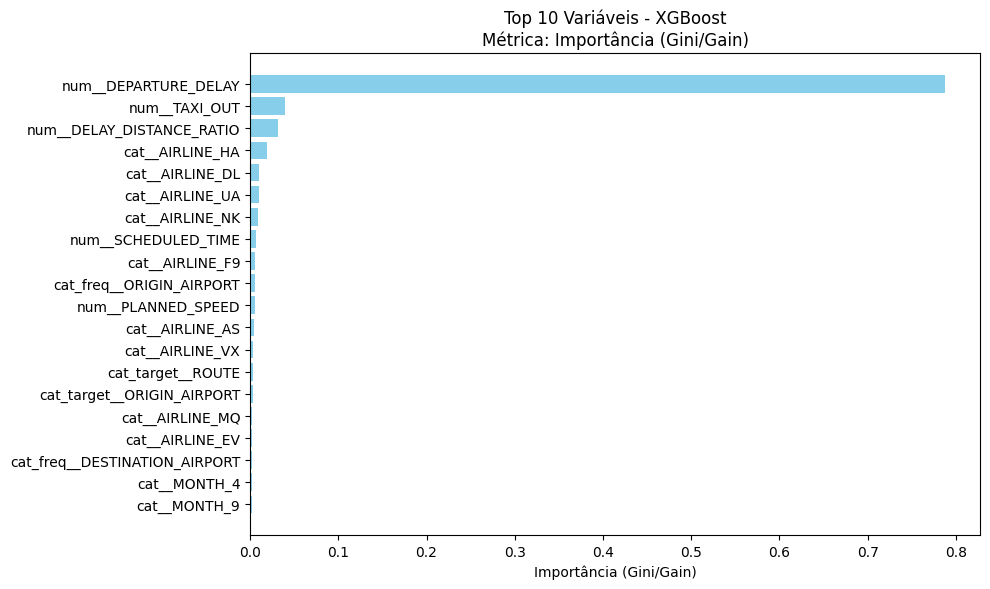

Analisando modelo: LinearRegression


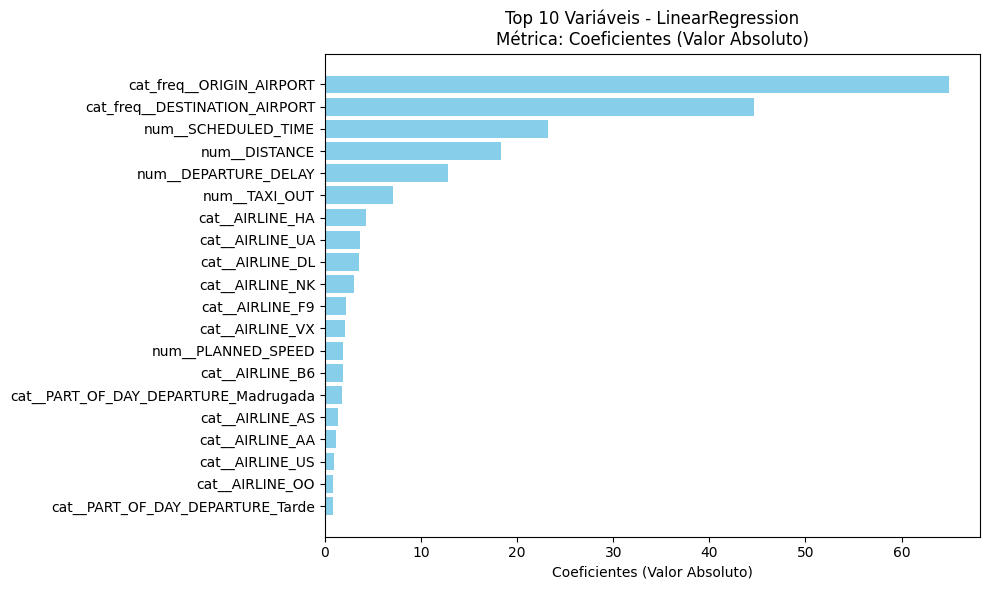

Analisando modelo: RandomForestRegressor


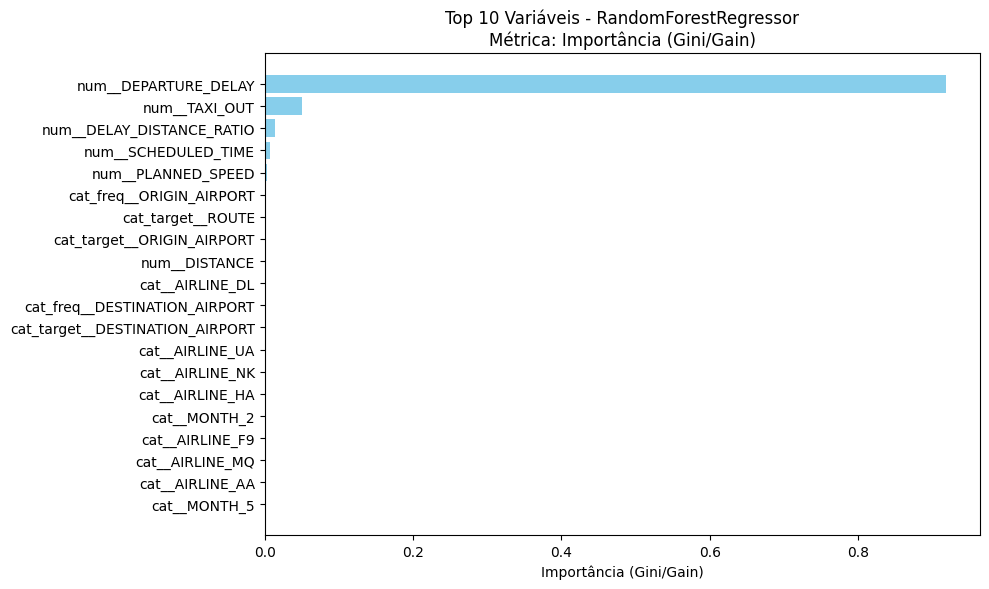

Analisando modelo: KNeighborsRegressor
O modelo 'KNeighborsRegressor' (ex: KNN) não possui atributo nativo de importância de features.


In [49]:
feature_names = preprocessor.get_feature_names_out()

for name, model in models_dict.items():
    print(f"Analisando modelo: {name}")
    importances = None
    metric_type = ""
    
    # Verifica se é modelo baseado em árvore (XGBoost, RandomForest)
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        metric_type = "Importância (Gini/Gain)"
        
    # Verifica se é modelo linear (LinearRegression)
    elif hasattr(model, 'coef_'):
        # Para regressão linear, usamos o valor absoluto do coeficiente como "importância"
        importances = np.abs(model.coef_)
        metric_type = "Coeficientes (Valor Absoluto)"
        
    # Modelos sem importância direta (ex: KNN)
    else:
        print(f"O modelo '{name}' (ex: KNN) não possui atributo nativo de importância de features.")
        continue

    df_imp = pd.DataFrame({
        'feature': feature_names, 
        'importance': importances
    })
    
    df_imp = df_imp.sort_values('importance', ascending=False).head(20)

    plt.figure(figsize=(10, 6))
    plt.barh(df_imp['feature'], df_imp['importance'], color='skyblue')
    plt.gca().invert_yaxis() # Inverte para o maior ficar no topo
    plt.title(f"Top 10 Variáveis - {name}\nMétrica: {metric_type}")
    plt.xlabel(metric_type)
    plt.tight_layout()
    plt.show()

# Hyperparameters session

In [50]:
def objective_xgboost(trial, X, y):
    """XGBoost"""
    params = {
        'objective': 'reg:absoluteerror', # Foco em MAE para reduzir impacto de outliers
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 15),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': 42,
        'n_jobs': -1
    }
    model = XGBRegressor(**params)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    score = cross_val_score(pipeline, X, y, cv=3, scoring='neg_mean_absolute_error', n_jobs=1)
    return score.mean()

In [51]:
def objective_random_forest(trial, X, y):
    """Random Forest"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 5, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'criterion': 'squared_error',
        'random_state': 42,
        'n_jobs': -1
    }
    model = RandomForestRegressor(**params)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    score = cross_val_score(pipeline, X, y, cv=3, scoring='neg_mean_absolute_error', n_jobs=1)
    return score.mean()

In [52]:
def objective_ridge(trial, X, y):
    """Ridge (Regressão Linear com regularização L2)"""
    params = {
        'alpha': trial.suggest_float('alpha', 0.1, 100.0, log=True),
        'random_state': 42
    }
    model = Ridge(**params)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    score = cross_val_score(pipeline, X, y, cv=3, scoring='neg_mean_absolute_error', n_jobs=1)
    return score.mean()


In [ ]:
def objective_knn(trial, X, y):
    """
    K-Neighbors Regressor (KNN).
    """
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 5, 50),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        # p=1: Manhattan distance, p=2: Euclidean distance
        'p': trial.suggest_int('p', 1, 2),
        'n_jobs': -1
    }
    model = KNeighborsRegressor(**params)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    score = cross_val_score(pipeline, X, y, cv=3, scoring='neg_mean_absolute_error', n_jobs=1)
    return score.mean()

In [54]:
strategies = {
    'XGBoost': objective_xgboost,
    'RandomForest': objective_random_forest,
    'Ridge': objective_ridge,
    'KNN': objective_knn
}

model_classes = {
    'XGBoost': XGBRegressor,
    'RandomForest': RandomForestRegressor,
    'Ridge': Ridge,
    'KNN': KNeighborsRegressor
}

In [ ]:
# Recriamos X_train e y_train com os dados ORIGINAIS (sem pré-processamento)
# Use o dataframe que saiu da limpeza de outliers (df_cleaned)

# Defina as colunas para remover (Targets e IDs irrelevantes)
cols_drop_setup = ['ARRIVAL_DELAY', 'DATE', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'DEPARTURE_TIME', 'ARRIVAL_TIME', 'SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL']
# Garante que só remove o que existe no df
valid_drop = [c for c in cols_drop_setup if c in df_cleaned.columns]

X_optuna = df_cleaned.drop(valid_drop, axis=1)
y_optuna = df_cleaned['ARRIVAL_DELAY']

# Split CRU (Raw Data)
# Nota: NÃO aplicamos o preprocessor aqui. Deixe o X_train_raw com as strings originais ('AA', 'JFK', etc)
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_optuna, y_optuna, test_size=0.2, random_state=42)

print("Dados crus preparados para o Optuna!")
print(f"Colunas no X_train_raw: {X_train_raw.columns.tolist()[:5]}") # Deve mostrar colunas originais

Dados crus preparados para o Optuna!
Colunas no X_train_raw: ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'ROUTE', 'MONTH']


In [56]:
studies = {}
best_models_map = {}
results_dict = {}


for model_name, objective_func in strategies.items():
    print(f"Otimizando {model_name}")
    
    # Cria um estudo novo para cada modelo
    study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
    
    study.optimize(lambda trial: objective_func(trial, X_train_raw, y_train_raw), n_trials=15)
    
    # Salva o estudo para análise posterior
    studies[model_name] = study
    best_params = study.best_params
    
    print ('='*60)
    print(f"Best Hyperparameters: {best_params}")
    print(f"Melhor {model_name}: {abs(study.best_value):.4f}")
    print("="*60)

    # --- Re-treino ---
    print(f"Re-treinando {model_name}...")
    
    final_params = best_params.copy()
    
    
    ModelClass = model_classes[model_name]
    
    best_model = ModelClass(**final_params)
    best_model.fit(X_train, y_train)
    best_models_map[model_name] = best_model # Guardar o modelo treinado
    
    # Avaliação no Teste
    y_pred = best_model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results_dict[model_name] = {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
    }

    print(f"--- Resultado Final (Teste) ---")
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2:   {r2:.4f}")
    
    try:
        fig1 = optuna.visualization.plot_optimization_history(study)
        fig1.show()
        
        fig2 = optuna.visualization.plot_parallel_coordinate(study)
        fig2.show()
        
        fig3 = optuna.visualization.plot_slice(study)
        fig3.show()
        
        # Importância dos parâmetros (pode falhar se houver poucos trials ou pouca variância)
        fig4 = optuna.visualization.plot_param_importances(study)
        fig4.show()
    except Exception as e:
        print(f"Aviso: Não foi possível gerar alguns gráficos do Optuna. Erro: {e}")

[I 2025-12-16 22:56:14,215] A new study created in memory with name: no-name-7776bcce-3492-4d21-be33-ab93deb7fc57


Otimizando XGBoost


[I 2025-12-16 22:57:37,195] Trial 0 finished with value: -6.546621799468994 and parameters: {'n_estimators': 437, 'max_depth': 10, 'learning_rate': 0.22227824312530747, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'min_child_weight': 3, 'gamma': 0.2904180608409973, 'reg_alpha': 0.6245760287469893, 'reg_lambda': 0.002570603566117598}. Best is trial 0 with value: -6.546621799468994.
[I 2025-12-16 23:01:26,721] Trial 1 finished with value: -6.29453722635905 and parameters: {'n_estimators': 737, 'max_depth': 3, 'learning_rate': 0.29127385712697834, 'subsample': 0.9162213204002109, 'colsample_bytree': 0.6061695553391381, 'min_child_weight': 3, 'gamma': 0.9170225492671691, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323}. Best is trial 1 with value: -6.29453722635905.
[I 2025-12-16 23:06:33,424] Trial 2 finished with value: -6.308177471160889 and parameters: {'n_estimators': 489, 'max_depth': 5, 'learning_rate': 0.18743733946949004, 'subsampl

Best Hyperparameters: {'n_estimators': 997, 'max_depth': 8, 'learning_rate': 0.08117886613391563, 'subsample': 0.5132167344504134, 'colsample_bytree': 0.777751009017812, 'min_child_weight': 6, 'gamma': 1.5364830605842434, 'reg_alpha': 0.00017751672073517406, 'reg_lambda': 0.022891327927378104}
Melhor XGBoost: 6.2474
Re-treinando XGBoost...
--- Resultado Final (Teste) ---
MAE:  6.4200
RMSE: 9.1628
R2:   0.9219


[I 2025-12-16 23:12:56,563] A new study created in memory with name: no-name-9ab70ab1-1266-47cb-9636-9dea8438d81c


Otimizando RandomForest


[I 2025-12-16 23:13:11,193] Trial 0 finished with value: -7.762778810472887 and parameters: {'n_estimators': 106, 'max_depth': 20, 'min_samples_split': 16, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 0 with value: -7.762778810472887.
[I 2025-12-16 23:13:35,729] Trial 1 finished with value: -8.103163028212093 and parameters: {'n_estimators': 180, 'max_depth': 14, 'min_samples_split': 16, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: -7.762778810472887.
[I 2025-12-16 23:14:01,403] Trial 2 finished with value: -7.718596567332727 and parameters: {'n_estimators': 77, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 2 with value: -7.718596567332727.
[I 2025-12-16 23:14:09,509] Trial 3 finished with value: -9.369253928671375 and parameters: {'n_estimators': 71, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 2 with value: -7.718596567332727.

Best Hyperparameters: {'n_estimators': 55, 'max_depth': 19, 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': None}
Melhor RandomForest: 6.8069
Re-treinando RandomForest...
--- Resultado Final (Teste) ---
MAE:  6.8176
RMSE: 9.6434
R2:   0.9134


[I 2025-12-16 23:19:30,602] A new study created in memory with name: no-name-9c2c1c1c-33ba-4425-a103-bbe1f4021466


Otimizando Ridge


[I 2025-12-16 23:19:32,066] Trial 0 finished with value: -6.77437626280054 and parameters: {'alpha': 1.3292918943162166}. Best is trial 0 with value: -6.77437626280054.
[I 2025-12-16 23:19:33,515] Trial 1 finished with value: -6.832883594864086 and parameters: {'alpha': 71.14476009343416}. Best is trial 0 with value: -6.77437626280054.
[I 2025-12-16 23:19:34,956] Trial 2 finished with value: -6.783658570550422 and parameters: {'alpha': 15.702970884055382}. Best is trial 0 with value: -6.77437626280054.
[I 2025-12-16 23:19:36,418] Trial 3 finished with value: -6.77517139863813 and parameters: {'alpha': 6.2513735745217485}. Best is trial 0 with value: -6.77437626280054.
[I 2025-12-16 23:19:37,887] Trial 4 finished with value: -6.774913847688029 and parameters: {'alpha': 0.2938027938703535}. Best is trial 0 with value: -6.77437626280054.
[I 2025-12-16 23:19:39,322] Trial 5 finished with value: -6.774913881466664 and parameters: {'alpha': 0.2937538457632829}. Best is trial 0 with value: -6

Best Hyperparameters: {'alpha': 2.653892435628575}
Melhor Ridge: 6.7741
Re-treinando Ridge...
--- Resultado Final (Teste) ---
MAE:  6.8547
RMSE: 9.6881
R2:   0.9126


[I 2025-12-16 23:19:53,341] A new study created in memory with name: no-name-4af08835-9001-46f5-b647-fdd86d5e96e3


Otimizando KNN


[I 2025-12-16 23:20:14,371] Trial 0 finished with value: -8.179426645291601 and parameters: {'n_neighbors': 22, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: -8.179426645291601.
[I 2025-12-16 23:20:30,490] Trial 1 finished with value: -8.171330583230807 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: -8.171330583230807.
[I 2025-12-16 23:20:43,388] Trial 2 finished with value: -8.23819823052614 and parameters: {'n_neighbors': 32, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: -8.171330583230807.
[I 2025-12-16 23:21:49,164] Trial 3 finished with value: -8.772712796803404 and parameters: {'n_neighbors': 43, 'weights': 'uniform', 'p': 1}. Best is trial 1 with value: -8.171330583230807.
[I 2025-12-16 23:22:50,873] Trial 4 finished with value: -8.653097081835654 and parameters: {'n_neighbors': 18, 'weights': 'uniform', 'p': 1}. Best is trial 1 with value: -8.171330583230807.
[I 2025-12-16 23:23:46,237] Trial 5 finished w

Best Hyperparameters: {'n_neighbors': 15, 'weights': 'uniform', 'p': 2}
Melhor KNN: 8.1611
Re-treinando KNN...
--- Resultado Final (Teste) ---
MAE:  8.0308
RMSE: 11.1011
R2:   0.8853


In [57]:
def plot_model_performance(results_dict):
    """
    Plota gráficos comparativos (Bar Charts) das métricas dos modelos.
    """
    # Extrair dados do dicionário para um DataFrame
    data = []
    for name, result in results_dict.items():
        data.append({
            'Model': name,
            'RMSE': result['RMSE'],
            'MAE': result['MAE'],
            'R2': result['R2'],
        })
    
    df_results = pd.DataFrame(data)
    
    df_results = df_results.sort_values(by='RMSE', ascending=True)

    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # Gráfico 1: RMSE (Menor é melhor)
    sns.barplot(x='RMSE', y='Model', data=df_results, ax=axes[0], palette='viridis', hue='Model', legend=False)
    axes[0].set_title('Comparação de RMSE (Menor é Melhor)')
    axes[0].set_xlabel('Root Mean Squared Error')
    
    for container in axes[0].containers:
        axes[0].bar_label(container, fmt='%.2f', padding=3)

    # Gráfico 2: R2 (Maior é melhor)
    # Reordenar para o R2 (Maior primeiro)
    df_r2 = df_results.sort_values(by='R2', ascending=False)
    sns.barplot(x='R2', y='Model', data=df_r2, ax=axes[1], palette='magma', hue='Model', legend=False)
    axes[1].set_title('Comparação de R2 (Maior é Melhor)')
    axes[1].set_xlabel('R2 Score')
    axes[1].set_xlim(0, 1) # O R2 ideal vai até 1
    
    for container in axes[1].containers:
        axes[1].bar_label(container, fmt='%.3f', padding=3)

    plt.tight_layout()
    plt.show()
    
    return df_results

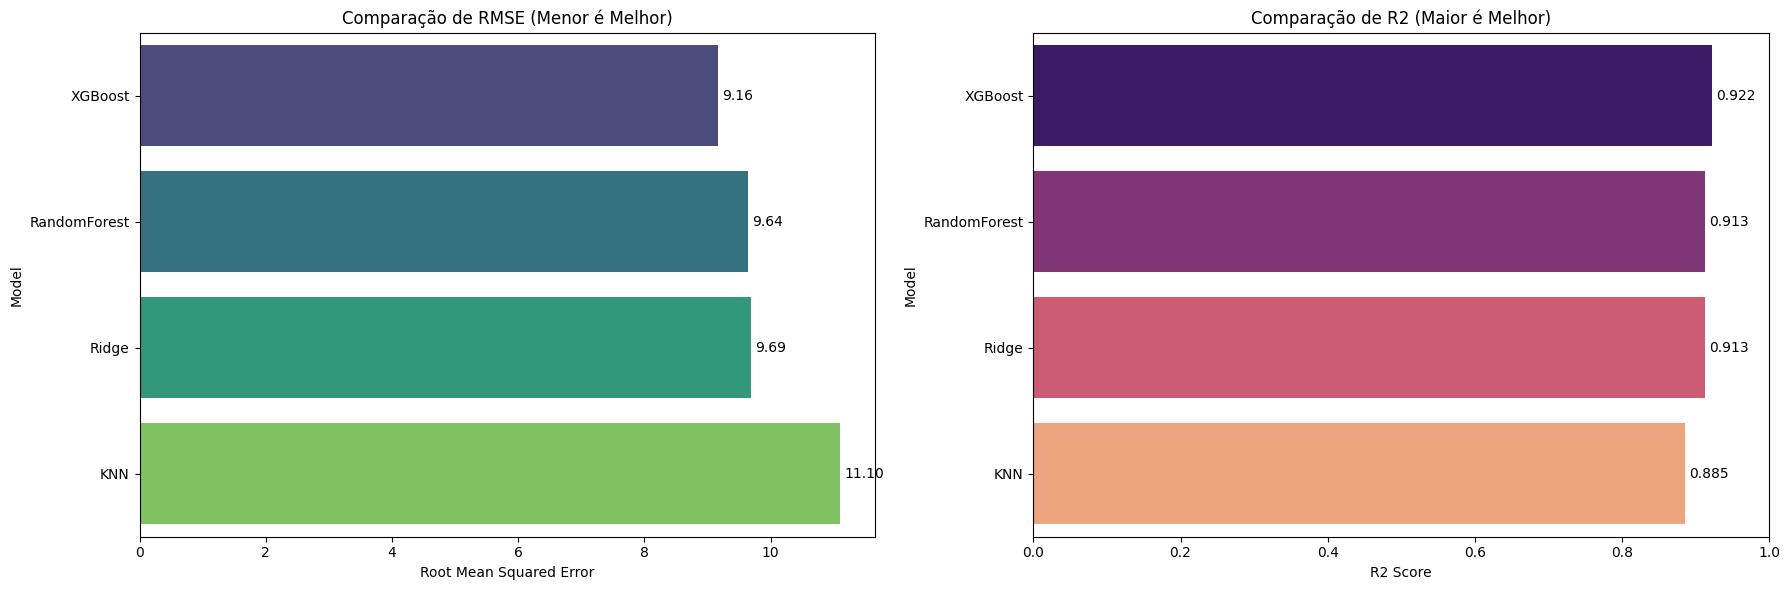

,Model,RMSE,MAE,R2
0,XGBoost,9.16,6.42,0.92
1,RandomForest,9.64,6.82,0.91
2,Ridge,9.69,6.85,0.91
3,KNN,11.10,8.03,0.89


In [58]:
plot_model_performance(results_dict)

Recuperando Melhores Parâmetros do XGBoost
Melhores Parâmetros: {'n_estimators': 997, 'max_depth': 8, 'learning_rate': 0.08117886613391563, 'subsample': 0.5132167344504134, 'colsample_bytree': 0.777751009017812, 'min_child_weight': 6, 'gamma': 1.5364830605842434, 'reg_alpha': 0.00017751672073517406, 'reg_lambda': 0.022891327927378104}


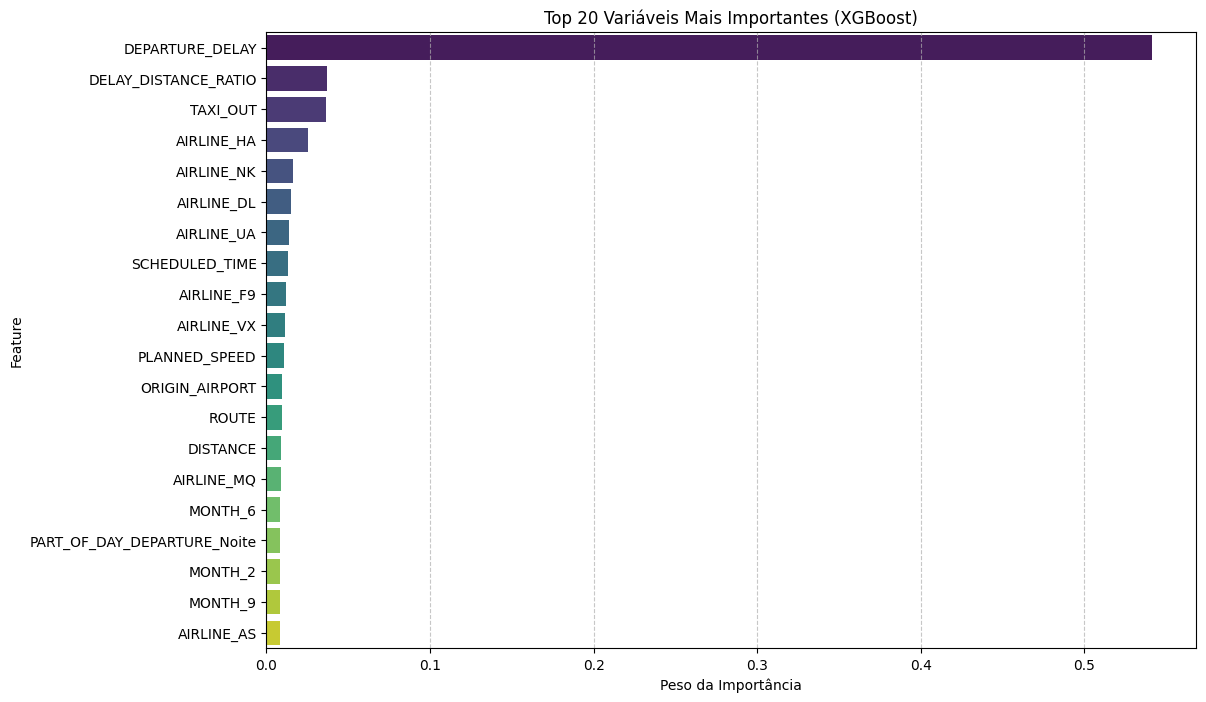

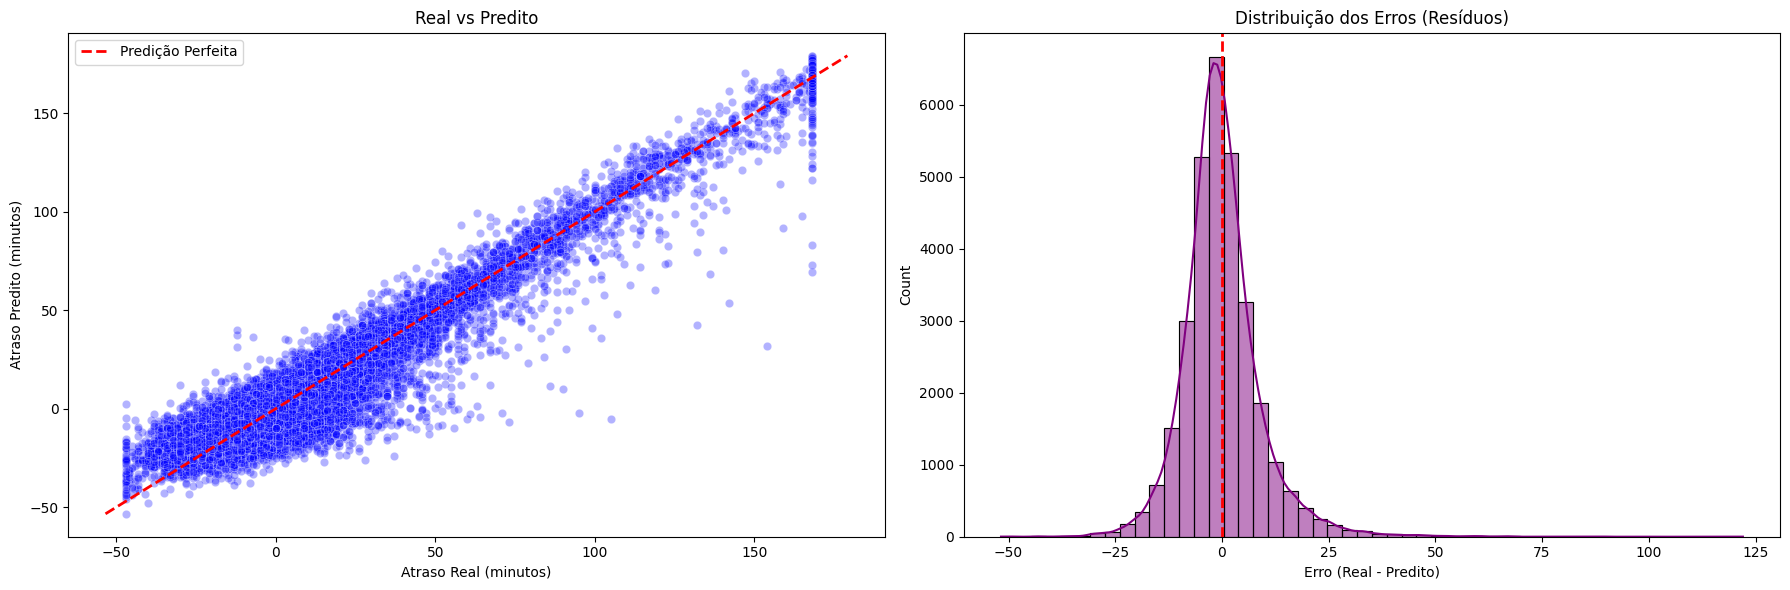

In [62]:
def analisar_modelo_final_processado(study_dict, X_train, y_train, X_test, y_test):
    """
    Função ajustada para dados JÁ PROCESSADOS.
    Ignora o pré-processador e treina o modelo direto no DataFrame transformado.
    """
    
    print("Recuperando Melhores Parâmetros do XGBoost")
        
    best_params = study_dict['XGBoost'].best_params
    print(f"Melhores Parâmetros: {best_params}")
    
    # Cria o modelo DIRETAMENTE (Sem Pipeline)
    model_final = XGBRegressor(**best_params, n_jobs=-1, random_state=42)
    model_final.fit(X_train, y_train)
    
    # Gera Predições
    y_pred = model_final.predict(X_test)
    residuos = y_test - y_pred
    
    
    # Pegamos os nomes das colunas diretamente do DataFrame processado
    feature_names = X_train.columns
    
    # Cria DataFrame de Importância
    df_importancia = pd.DataFrame({
        'Feature': feature_names,
        'Importance': model_final.feature_importances_
    })
    
    # Limpa os nomes para o gráfico ficar mais legível
    # Remove os prefixos que o Scikit-Learn adicionou
    df_importancia['Feature'] = df_importancia['Feature'].str.replace('num__', '').str.replace('cat__', '').str.replace('cat_freq__', '').str.replace('cat_target__', '')
    
    # Ordena e pega as Top 20
    df_importancia = df_importancia.sort_values(by='Importance', ascending=False).head(20)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=df_importancia, palette='viridis', hue='Feature', legend=False)
    plt.title('Top 20 Variáveis Mais Importantes (XGBoost)')
    plt.xlabel('Peso da Importância')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

    # --- GRÁFICO 2: ANÁLISE DE RESÍDUOS ---
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # Scatter: Real vs Predito
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.3, ax=axes[0], color='blue')
    
    # Linha de referência (Predição Perfeita)
    max_val = max(y_test.max(), y_pred.max())
    min_val = min(y_test.min(), y_pred.min())
    axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Predição Perfeita')
    
    axes[0].set_title('Real vs Predito')
    axes[0].set_xlabel('Atraso Real (minutos)')
    axes[0].set_ylabel('Atraso Predito (minutos)')
    axes[0].legend()
    
    # Histograma dos Erros
    sns.histplot(residuos, bins=50, kde=True, ax=axes[1], color='purple')
    axes[1].set_title('Distribuição dos Erros (Resíduos)')
    axes[1].set_xlabel('Erro (Real - Predito)')
    axes[1].axvline(0, color='red', linestyle='--', lw=2)
    
    plt.tight_layout()
    plt.show()
    
analisar_modelo_final_processado(studies, X_train, y_train, X_test, y_test)

# Conclusões

Desempenho dos Modelos: O modelo XGBoost apresentou a melhor performance geral entre os testados, alcançando um R² de 0.92 e um MAE (Erro Médio Absoluto) de aproximadamente 6.44 minutos. Isso indica que o modelo consegue explicar 92% da variância dos dados de teste, superando a Regressão Linear (R² 0.91), Random Forest (R² 0.90) e KNN (R² 0.88).